In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy.io import fits
import glob
plt.rcParams['image.origin'] ='lower'
from matplotlib.patches import Ellipse

## Conceptual Tests

In [3]:
def inc(a,b):
    i = np.arccos(b/a)
    i = np.rad2deg(i)
    return i

In [4]:
b = np.asarray([10,9,8,7,6,5,4,3,2,1,0.1])
a = np.full_like(b,10)
print(b/a)

[1.   0.9  0.8  0.7  0.6  0.5  0.4  0.3  0.2  0.1  0.01]


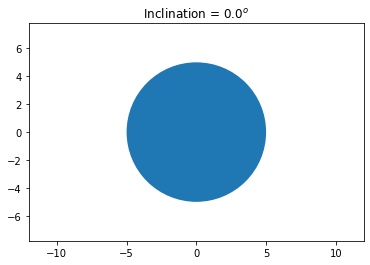

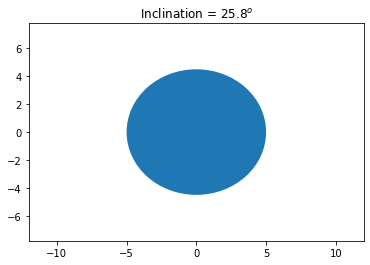

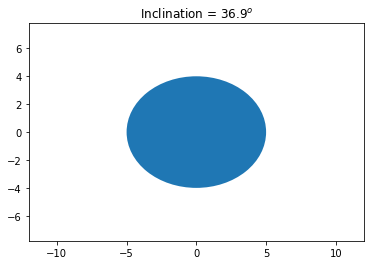

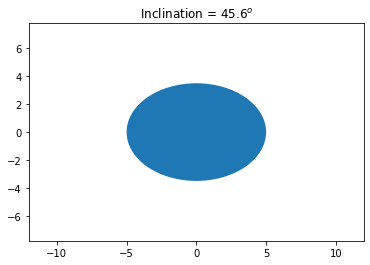

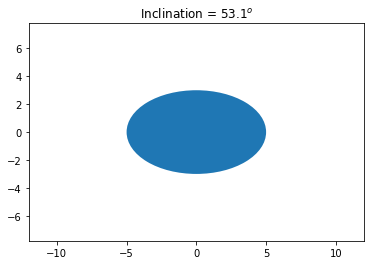

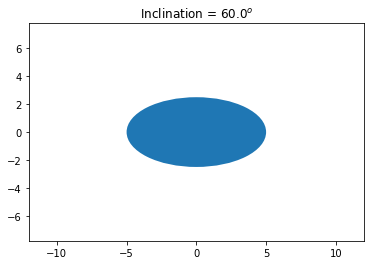

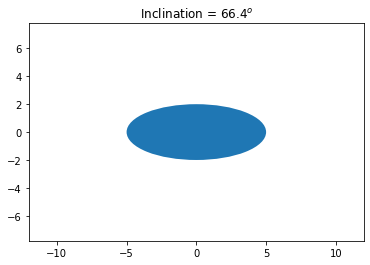

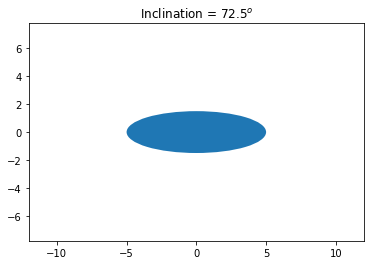

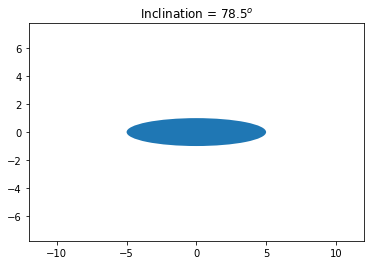

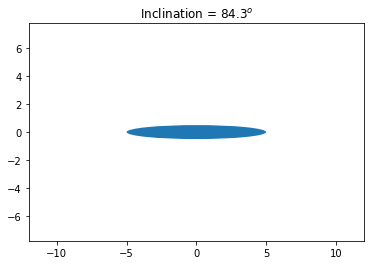

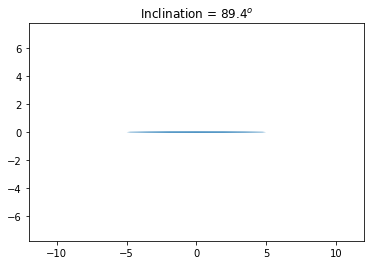

In [5]:
incs = inc(a,b)
for test in range(0,len(a)):
    fig = plt.figure(0)
    ax = plt.gca()
    e = Ellipse(xy=(0,0), width=a[test], height=b[test], angle=0)
    ax.add_artist(e)
    ax.axis('equal')
    plt.xlim(-12,12)
    plt.ylim(-12,12)
    plt.title('Inclination = {}$^o$'.format(round(incs[test],1)))
    #plt.savefig('ellipse-tilt-{}.png'.format(round(incs[test])))
    plt.show()

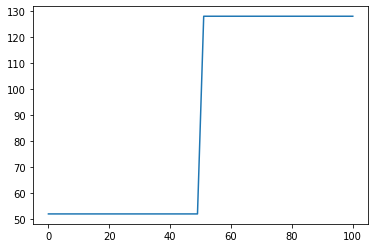

In [6]:
#let's try my simple theta_i + theta_s = 90 for on axis to see how that works
def theta_s(theta_i,y):
    if y<50:
        ts = 90-theta_i
    else:
        ts = 180-(90-theta_i)
    return ts

y = np.linspace(0,100)
ts = []
for i in y:
    ts.append(theta_s(38,i))
plt.plot(y,ts)

Keplerian Orbits playground, using code from Mike (thanks Mike)

In [53]:
def keplerian_solver(M, e):
    """Solve Kepler's equation, returning E given M, e.

       M = E - e*sin(E)

    Only handles multiple values of mean anomaly (M), not eccentricity (e)
    """
    assert e >= 0.
    assert e < 1.

    MM = np.asarray(M)
    if MM.shape == (): # scalar case
        MM.shape = (1,)

    from scipy.optimize import fmin
    def kep(E, M):
        return np.sum(np.abs(M-E+e*np.sin(E)))
    E0 = MM + np.sign(np.sin(MM)) * 0.85 * e # initial guess
    E = np.empty_like(MM)
    for i, M in enumerate(MM):
        E[i] = fmin(kep, E0[i], args=(M,),
                    disp=False,
                    #maxiter=500,
                    #maxfun=500,
                    )
    return E

def get_apparent_orbit(a, e, inc, omega, Omega, M):
    """
    a      semimajor axis [AU]
    e      eccentricity
    inc    inclination [rad]
    omega  argument of periastron [rad]
    Omega  longitude of ascending node [rad]  relative to x axis, counterclockwise
    M      mean anomaly [rad]

    returns x, y, z triplet [AU]
      x is North
      y is East
    """

    # compute eccentric anomaly
    E = keplerian_solver(M, e) # [rad] eccentric anomaly

    # compute true anomaly
    nu = 2.*np.arctan2(np.sqrt(1.+e)*np.sin(E/2.), np.sqrt(1.-e)*np.cos(E/2.)) # [rad]

    # compute radius
    r = a * (1.-e**2) / (1.+e*np.cos(nu)) # [AU]

    so, co = np.sin(omega), np.cos(omega)
    sonu, conu = np.sin(omega+nu), np.cos(omega+nu)
    sO, cO = np.sin(Omega), np.cos(Omega)
    si, ci = np.sin(inc), np.cos(inc)

    x = r * (cO*conu-sO*sonu*ci) # [AU]
    y = r * (sO*conu+cO*sonu*ci) # [AU]
    z = r * sonu*si

    return x, y, z

In [54]:
x,y,z = get_apparent_orbit(185,0,np.deg2rad(36),0,np.deg2rad(68),np.linspace(0,2*np.pi))

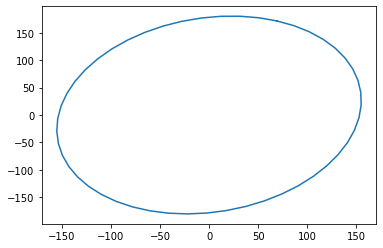

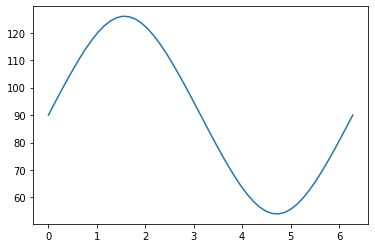

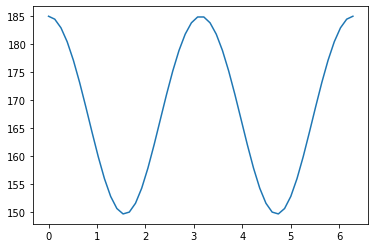

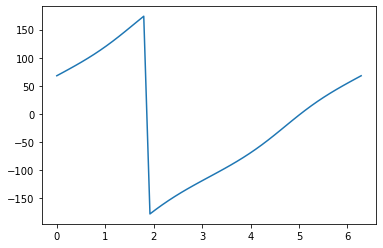

68.0


In [55]:
plt.plot(x,y)
plt.show()
# scattering angle
phi_sca = np.pi - np.arccos(z/(np.sqrt(x**2+y**2+z**2))) # [rad]
# projected radius
r_proj = np.sqrt(x**2+y**2) # [AU]
# projected PA        
PA_proj = np.arctan2(y, x)
plt.plot(np.linspace(0,2*np.pi), np.rad2deg(phi_sca))
plt.show()
plt.plot(np.linspace(0,2*np.pi), r_proj)
plt.show()
plt.plot(np.linspace(0,2*np.pi), np.rad2deg(PA_proj))
plt.show()
print(np.rad2deg(PA_proj[0]))

In [56]:
def get_apparent_orbit_ellipse(a, e, inc, omega, Omega):
    """
    a      semimajor axis [AU]
    e      eccentricity
    inc    inclination [rad]
    omega  argument of periastron [rad]
    Omega  longitude of ascending node [rad]  relative to x axis, counterclockwise

    returns a, b, phi, E0, N0

    ap, bp, phi, E0, N0 = get_apparent_orbit_ellipse(a, e, inc, omega, Omega)
    ax.add_artist(mpl.patches.Ellipse((E0,N0),
                                      width=2.*ap, height=2.*bp,
                                      angle=phi*180./n.pi,
                                      ))

    Be sure that the x coordinate is East (increases to left)
    """

    # compute Thiele-Innes elements
    A = a*(np.cos(omega)*np.cos(Omega)-np.sin(omega)*np.sin(Omega)*np.cos(inc))
    B = a*(np.cos(omega)*np.sin(Omega)+np.sin(omega)*np.cos(Omega)*np.cos(inc))
    F = a*(-np.sin(omega)*np.cos(Omega)-np.cos(omega)*np.sin(Omega)*np.cos(inc))
    G = a*(-np.sin(omega)*np.sin(Omega)+np.cos(omega)*np.cos(Omega)*np.cos(inc))

    # compute coefficients for general ellipse
    a = (F**2+A**2/(1.-e**2))
    b = -(F*G+A*B/(1.-e**2))
    c = (G**2+B**2/(1.-e**2))
    d = e*F*(B*F-A*G)
    f = -e*G*(B*F-A*G)
    g = -(1.-e**2)*(B*F-A*G)**2

    # solve for ellipse parameters
    E0 = (c*d-b*f) / (b**2-a*c)
    N0 = (a*f-b*d) / (b**2-a*c)
    ap = np.sqrt(2.*(a*f**2+c*d**2+g*b**2-2.*b*d*f-a*c*g) / \
                (b**2-a*c) / (np.sqrt((a-c)**2+4.*b**2)-(a+c)))
    bp = np.sqrt(2.*(a*f**2+c*d**2+g*b**2-2.*b*d*f-a*c*g) / \
                (b**2-a*c) / (-np.sqrt((a-c)**2+4.*b**2)-(a+c)))
    if b==0.:
        phi = 0. if a<c else np.pi/2
    else:
        phi = np.arctan(2.*b/(a-c))/2.
        if a>=c: phi += np.pi/2.

    return ap, bp, phi, E0, N0


In [57]:
def test_apparent_orbit():
    import matplotlib as mpl
    import pylab

    nn = 100
    M = np.linspace(0., 2.*np.pi, nn) # [rad]

    a = 10. # [AU]
    e = 0
    inc = 36 * np.pi/180. # [rad]
    omega = 30. * np.pi/180. # [rad]
    Omega = 68 * np.pi/180. # [rad]

    N, E, z = get_apparent_orbit(a, e, inc, omega, Omega, M) # orbit
    Np, Ep, zp = get_apparent_orbit(a, e, inc, omega, Omega, 0.) # peri
    ap, bp, phi, E0, N0 = get_apparent_orbit_ellipse(a, e, inc, omega, Omega)
    
    fig = pylab.figure(0)
    fig.clear()
    #fig.hold(True)
    ax = fig.add_subplot(111)

    # plot orbit
    ax.plot(E[:int(nn/2)],N[:int(nn/2)], lw=2)
    ax.plot(E[int(nn/2):],N[int(nn/2):])

    ax.set_autoscale_on(False)

    # mark line of nodes
    ax.plot((2.*a*np.sin(Omega), -2.*a*np.sin(Omega)),
            (2.*a*np.cos(Omega), -2.*a*np.cos(Omega)),
            ls=':', c='k')
    # ascending node
    r = a * (1.-e**2) / (1.+e*np.cos(-omega)) # [AU]
    N = r * np.cos(Omega) # [AU]
    E = r * np.sin(Omega) # [AU]
    ax.scatter((E,),(N,),c='k')

    # mark peri
    ax.scatter(Ep,Np,color='red')
    # mark star
    ax.scatter((0.,),(0.,))

    # plot orbit ellipse
    ax.add_artist(mpl.patches.Ellipse((E0,N0),
                                      width=2.*ap, height=2.*bp,
                                      angle=phi*180./np.pi,
                                      ec='k', fc='none',
                                      alpha=0.15,
                                      lw=5,
                                      ))
    
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_aspect('equal')
    ax.set_xlabel('E')
    ax.set_ylabel('N')
    pylab.draw()
    pylab.show()
    print(phi*180./np.pi)

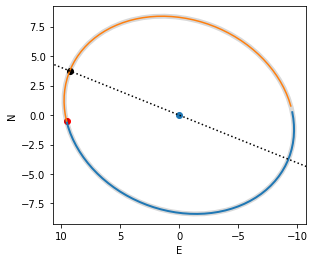

21.999999999999996
68


In [59]:
test_apparent_orbit()
print(90-22)

## Disk Geometry and Scattering Angle

In [7]:
##from pauline notes and code
nu = np.deg2rad(np.linspace(0,360,100))
r = 1 #radius from ring center [AU]
offset = 0 #[AU]
I = np.deg2rad(36) #inclination [rad]
omega = 0 # argument of pericenter (for offset) [rad]
Omega = np.deg2rad(68) #longitude of ascending node [rad]

In [8]:
so, co = np.sin(omega), np.cos(omega)
sonu, conu = np.sin(omega+nu), np.cos(omega+nu)
sO, cO = np.sin(Omega), np.cos(Omega)
si, ci = np.sin(I), np.cos(I)

#Euler angle transformation
pN_noff = r * (cO*conu-sO*sonu*ci) # [AU]
pE_noff = r * (sO*conu+cO*sonu*ci) # [AU]
pz_noff = r * sonu*si

oN = offset * (cO*co-sO*so*ci) # [AU]
oE = offset * (sO*co+cO*so*ci) # [AU]
oz = offset * so*si # [AU]

#Subtract offset angles
pN = pN_noff - oN
pE = pE_noff - oE
pz = pz_noff - oz

r_star = np.sqrt(pN**2 + pE**2 + pz**2)

# sczattering angle
phi_sca = np.pi - np.arccos(pz/r_star) # [rad]

# projected radius
r_proj = np.sqrt(pN**2+pE**2) # [AU]

# projected PA        
PA_proj = np.arctan2(pE, pN)

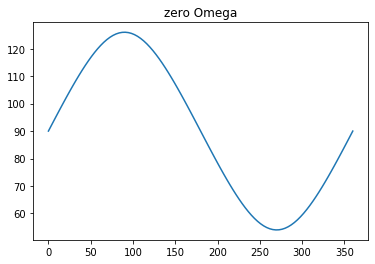

In [9]:
plt.title('zero Omega')
plt.plot(np.rad2deg(nu),np.rad2deg(phi_sca))
plt.show()

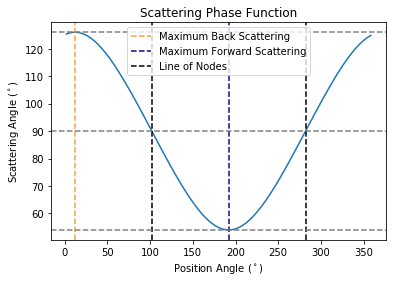

In [10]:
plt.title('Scattering Phase Function')
PA = np.copy(nu)
for i in range(len(nu)):
    n = np.rad2deg(nu[i])
    PA[i] = n-90+12
    if PA[i]>360:
        PA[i]=PA[i]-360
    if PA[i]<0:
        PA[i]=360+PA[i]
x2,y2 = zip(*sorted(zip(PA,np.rad2deg(phi_sca)),key=lambda PA: PA[0]))
plt.plot(x2,y2)
plt.xlabel('Position Angle ($^\circ$)')
plt.ylabel('Scattering Angle ($^\circ$)')
cmap = plt.get_cmap('plasma')
plt.axvline(12,linestyle='dashed',color=cmap(200),label='Maximum Back Scattering')
plt.axvline(12+180,linestyle='dashed',color=cmap(0),label='Maximum Forward Scattering')
plt.axvline(90+12,linestyle='dashed',color='k',label='Line of Nodes')
plt.axvline(90+12+180,linestyle='dashed',color='k')
plt.axhline(np.max(np.rad2deg(phi_sca)),linestyle='dashed',color='grey')
plt.axhline(90,linestyle='dashed',color='grey')
plt.axhline(np.min(np.rad2deg(phi_sca)),linestyle='dashed',color='grey')
plt.legend()
#plt.savefig('phi-sca-line.png',dpi=500)
plt.show()

#saving for phase function calcs
np.save('scatt-angle',y2,allow_pickle=True)
np.save('PA',x2,allow_pickle=True)

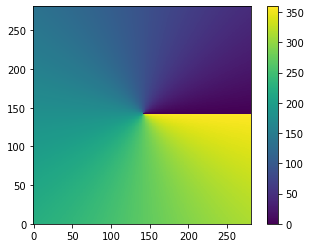

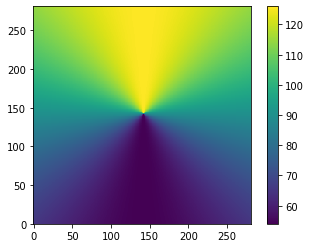

126.0 53.99999999999997


In [51]:
def phi(nu):
    so, co = np.sin(omega), np.cos(omega)
    sonu, conu = np.sin(omega+nu), np.cos(omega+nu)
    sO, cO = np.sin(Omega), np.cos(Omega)
    si, ci = np.sin(I), np.cos(I)

    #Euler angle transformation
    pN_noff = r * (cO*conu-sO*sonu*ci) # [AU]
    pE_noff = r * (sO*conu+cO*sonu*ci) # [AU]
    pz_noff = r * sonu*si

    oN = offset * (cO*co-sO*so*ci) # [AU]
    oE = offset * (sO*co+cO*so*ci) # [AU]
    oz = offset * so*si # [AU]

    #Subtract offset angles
    pN = pN_noff - oN
    pE = pE_noff - oE
    pz = pz_noff - oz

    r_star = np.sqrt(pN**2 + pE**2 + pz**2)

    # sczattering angle
    phi_sca = np.pi - np.arccos(pz/r_star) # [rad]
    return phi_sca

theta = np.zeros((281,281))
scatt = np.zeros((281,281))
for x in range(0,281):  
    for y in range(0,281):
        theta[x,y] = np.rad2deg(np.arctan2((x-center[0]),y-center[1]))
        if theta[x,y]<0:
            theta[x,y] = 360+theta[x,y]
        scatt[x,y] = np.rad2deg(phi(np.deg2rad(theta[x,y])))
            
plt.imshow(theta)
plt.colorbar()
plt.ylim(0,281)
plt.show()

plt.imshow(scatt)
plt.colorbar()
plt.ylim(0,281)
plt.show()

print(np.max(scatt),np.min(scatt))

127.31590600489052 51.60567024293446


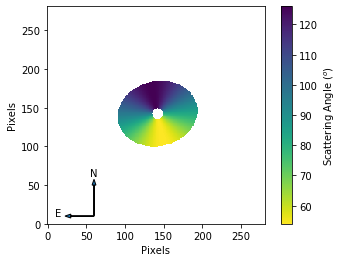

In [52]:
center = [142,142]
a=51.7     #radius on the x-axis
b=41.7    #radius on the y-axis

from scipy.ndimage import rotate
from matplotlib.patches import Ellipse

d = 1/(8.9484e-3)
ps = 14.2e-3
def pix_to_AU(pixval,ps,d):
    #pixval in # pixels, platescale in arcsec/pix and d in pc
    sep = d*206265*(pixval*ps*2e-5)
    return sep

from imgmasks import ellipse
scatt2 = rotate(scatt,-12,reshape=False)
e = ellipse.Ellipse([142,142],a,b,np.shape(scatt),theta=12)
masked = e.apply_elliptical_mask(scatt2)
masked[masked==0]=np.nan

zeros = np.full((281,281),np.nan)
for x in range(0,281):  
    for y in range(0,281):
        if np.sqrt(((x-center[1])**2 + (y-center[0])**2))>7:
            zeros[x,y]=1

plt.imshow(masked*zeros,cmap='viridis_r')
plt.colorbar(label='Scattering Angle ($^o$)')
plt.ylim(0,281)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.arrow(60,10,0,40,head_width=5,label='N')
plt.annotate('N',[55,62])
plt.arrow(60,10,-30,0,head_width=5,label='E')
plt.annotate('E',[10,10])
plt.savefig('../plots/scattering-angle.png')
print(np.max(masked[~np.isnan(masked)]),np.min(masked[~np.isnan(masked)]))

## Phase Functions